<a href="https://colab.research.google.com/github/shivamsurya/ladybot/blob/master/PySpark_Tutorial_EDA_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 3

Let's Mount the google drive

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Setting up Environment

In [3]:
#!pip install pyspark
!pip install pyspark==3.0.1 py4j==0.10.9 

     |████████████████████████████████| 204.2 MB 32 kB/s 
     |████████████████████████████████| 198 kB 63.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612246 sha256=c2d65e1689049eec35a082be8bedf652fe6a065017b24e1e629e72a265507cad
  Stored in directory: /root/.cache/pip/wheels/5e/34/fa/b37b5cef503fc5148b478b2495043ba61b079120b7ff379f9b
Successfully built pyspark


Creating Spark Session

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, struct
import matplotlib.pyplot as plts
import seaborn as sns

In [5]:
spark = SparkSession.builder.appName('PySpark_Tutorial-EDA').getOrCreate()

### Uploading datafile

In [10]:
Ad_csv_path = '/content/drive/MyDrive/EDA_Data/advertisement_sales.csv'

In [11]:
Ad_df = spark.read.format('csv').option('inferSchema', True).option('header', True).load(Ad_csv_path)

To look at the datafile

In [12]:
Ad_df.show()

+-----+--------+---------+-----+
|   TV|Facebook|Newspaper|Sales|
+-----+--------+---------+-----+
|230.1|    37.8|     40.0| 2210|
| 44.5|    39.3|     45.1| 1200|
| 17.2|    45.9|     50.0|  930|
|151.5|    41.3|     58.5| 1850|
|180.8|    10.8|     21.0| 1700|
|  8.7|    48.9|     55.0|  720|
| 57.5|    32.8|     23.5| 1180|
|120.2|    19.6|     11.6| 1320|
|  8.6|     2.1|      1.0|  480|
|199.8|     2.6|      4.0| 1300|
| 66.1|     5.8|      7.0|  860|
|214.7|    24.0|      4.0| 2000|
| 23.8|    35.1|     40.0|  920|
| 97.5|     7.6|      7.2|  970|
|204.1|    32.9|     46.0| 1900|
|195.4|    47.7|     52.9| 2240|
| 67.8|    36.6|     80.0| 1250|
|281.4|    39.6|     47.0| 2700|
| 69.2|    20.5|     18.3| 1130|
|147.3|    23.9|     19.1| 1460|
+-----+--------+---------+-----+
only showing top 20 rows



### Describe (): used for Univariate analysis 

In [13]:
Ad_df.describe().show()

+-------+-----------------+------------------+------------------+-----------------+
|summary|               TV|          Facebook|         Newspaper|            Sales|
+-------+-----------------+------------------+------------------+-----------------+
|  count|              200|               200|               200|              200|
|   mean|         147.0425|26.868500000000022|29.826999999999984|           1476.7|
| stddev|85.85423631490805|17.504530863572686| 19.37490920063016|554.6632914067516|
|    min|              0.7|               0.0|               1.0|              160|
|    max|            296.4|              90.0|             100.9|             2700|
+-------+-----------------+------------------+------------------+-----------------+



### Skewness and Kurtosis

In [14]:
from pyspark.sql.functions import col, skewness, kurtosis
Ad_df.select(skewness(Ad_df.Sales),kurtosis(Ad_df.Sales)).show()

+-------------------+-------------------+
|    skewness(Sales)|    kurtosis(Sales)|
+-------------------+-------------------+
|0.12534439501106742|-0.9059486483772443|
+-------------------+-------------------+



### Box Plot and Violin Plot

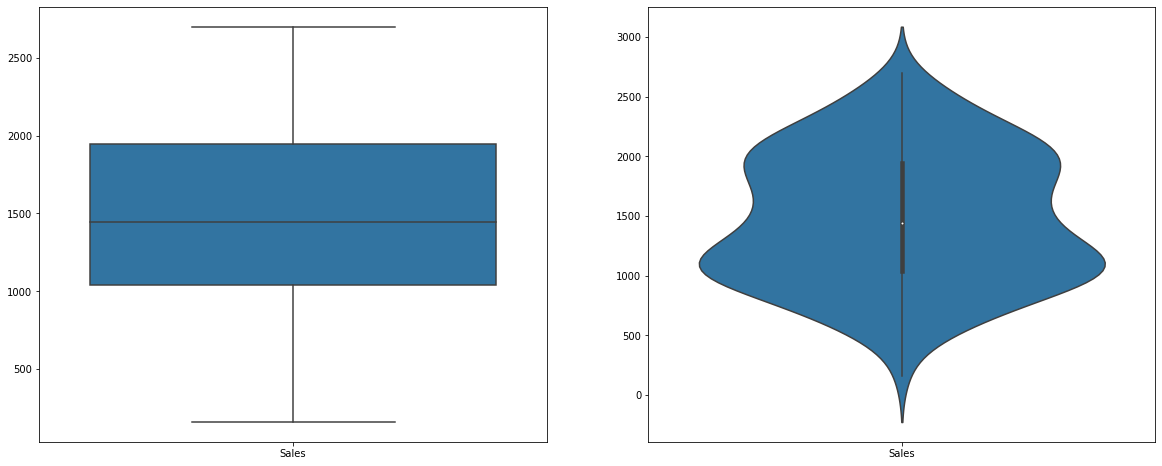

In [15]:
x = Ad_df.select(Ad_df.Sales).toPandas()

fig = plts.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
ax = sns.boxplot(data=x)

ax = fig.add_subplot(1, 2, 2)
ax = sns.violinplot(data=x)

### Multivariate Analysis

### Correlation

In [16]:
from pyspark.mllib.stat import Statistics
import pandas as pd


corr_data = Ad_df.select('*')

col_names = corr_data.columns
features = corr_data.rdd.map(lambda row: row[0:])
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)
corr_df.index, corr_df.columns = col_names, col_names

print(corr_df.to_string())

                 TV  Facebook  Newspaper     Sales
TV         1.000000  0.127597   0.088428  0.880802
Facebook   0.127597  1.000000   0.770426  0.392442
Newspaper  0.088428  0.770426   1.000000  0.301519
Sales      0.880802  0.392442   0.301519  1.000000


### Scatter Plot

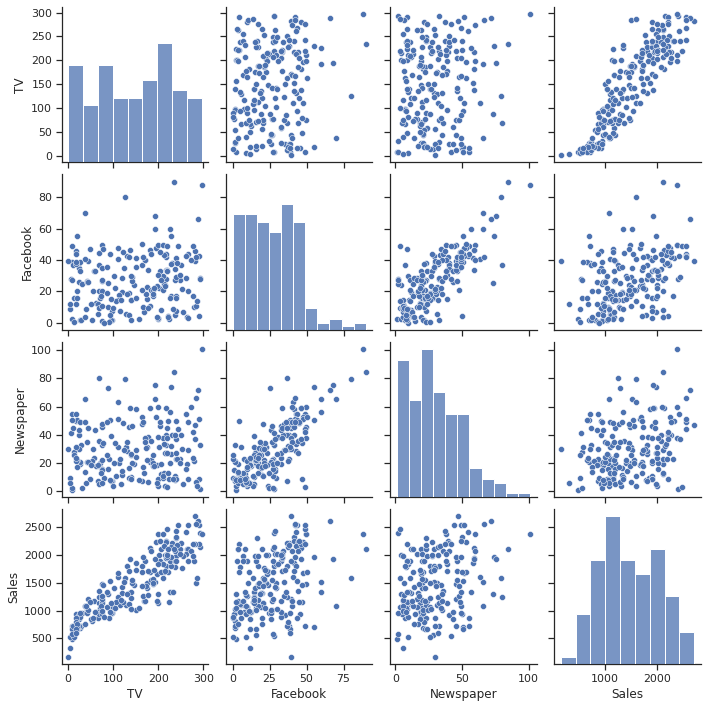

In [18]:
import seaborn as sns
sns.set(style="ticks")

sns.pairplot(Ad_df.select('*').toPandas())
plts.show()

## Regression


In [19]:
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

### Step 1: Convert the data to dense vector (features and label)

In [20]:
def transData(data):
  return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

### Step 2: Transform the dataset to DataFrame

In [21]:
transformed= transData(Ad_df)
transformed.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[230.1,37.8,40.0]| 2210|
| [44.5,39.3,45.1]| 1200|
| [17.2,45.9,50.0]|  930|
|[151.5,41.3,58.5]| 1850|
|[180.8,10.8,21.0]| 1700|
+-----------------+-----+
only showing top 5 rows



### Step 3: Split the data into training and test sets (40% held out for testing)

In [22]:
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

In [23]:
trainingData.show(5)
testData.show(5)

+---------------+-----+
|       features|label|
+---------------+-----+
|[0.7,39.6,30.0]|  160|
| [4.1,11.6,5.7]|  320|
|  [5.4,9.0,9.4]|  530|
|[7.3,28.1,41.4]|  550|
|[7.8,38.9,50.6]|  660|
+---------------+-----+
only showing top 5 rows

+----------------+-----+
|        features|label|
+----------------+-----+
|[11.7,36.9,45.2]|  730|
| [13.1,0.4,25.6]|  530|
|[16.9,43.7,55.0]|  870|
|[17.2,39.0,31.6]|  590|
|[18.7,12.1,23.4]|  670|
+----------------+-----+
only showing top 5 rows



### Step 4: Fit Ordinary Least Square Regression Model

In [24]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()

### Step 5: Fit Liner Regression

In [25]:
model = lr.fit(trainingData)

In [26]:
model

LinearRegressionModel: uid=LinearRegression_0be73b99df5a, numFeatures=3

### Step 6: Make predictions

In [27]:
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("features","label", "prediction").show(5)

+----------------+-----+-----------------+
|        features|label|       prediction|
+----------------+-----+-----------------+
|[11.7,36.9,45.2]|  730| 824.599153104007|
| [13.1,0.4,25.6]|  530|526.7760153496722|
|[16.9,43.7,55.0]|  870|916.7905279247307|
|[17.2,39.0,31.6]|  590|857.1325379752686|
|[18.7,12.1,23.4]|  670|  646.80586842819|
+----------------+-----+-----------------+
only showing top 5 rows



### Step 7: Evaluation

In [28]:
from pyspark.ml.evaluation import RegressionEvaluator

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 163.422


### R square value

In [29]:
y_true = predictions.select("label").toPandas()
y_pred = predictions.select("prediction").toPandas()

In [30]:
import sklearn.metrics
r2_score = sklearn.metrics.r2_score(y_true, y_pred)
print('r2_score: {:4.3f}'.format(r2_score))

r2_score: 0.888
